In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import io

from google.colab import drive

Using TensorFlow backend.


In [2]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
X1 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_1_X.npy')
X2 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_2_X.npy')
X3 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_3_X.npy')
X4 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_4_X.npy')

In [0]:
Y1 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_1_Y.npy')
Y2 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_2_Y.npy')
Y3 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_3_Y.npy')
Y4 = np.load('/drive/My Drive/Colab Notebooks/train_cnn_4_Y.npy')

In [0]:
X_train = np.concatenate((X1,X2,X3,X4))
Y_train = np.concatenate((Y1,Y2,Y3,Y4))

X_test = np.load('/drive/My Drive/Colab Notebooks/test_cnn_4_X.npy')
Y_test = np.load('/drive/My Drive/Colab Notebooks/test_cnn_4_Y.npy')

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(3, activation = 'softmax')) # 3 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='/drive/My Drive/Colab Notebooks/best_model_4.h5', 
                                 monitor='val_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

# shape of the input images
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, Y_train, X_test, Y_test, 100, 15)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 100, 32)       3232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 25, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1433728   
_________________________________________________________________
dense_2 (Dense)              (None, 54)               

In [0]:
# X_test2 = np.load('/drive/My Drive/Colab Notebooks/test_cnn_2_X.npy')
# Y_test2 = np.load('/drive/My Drive/Colab Notebooks/test_cnn_2_Y.npy')

In [0]:
# from keras.models import model_from_json

# # load json and create model
# json_file = open('/drive/My Drive/Colab Notebooks/cnn_model_arch.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("/drive/My Drive/Colab Notebooks/best_model_1.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(
#         optimizer=keras.optimizers.Adam(),
#         loss='categorical_crossentropy',
#         metrics=['categorical_accuracy'])

[[ 1069.   428.   517.]
 [ 9057. 35854. 10356.]
 [  437.   420.  1198.]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(51.0, 0.5, 'True Label')

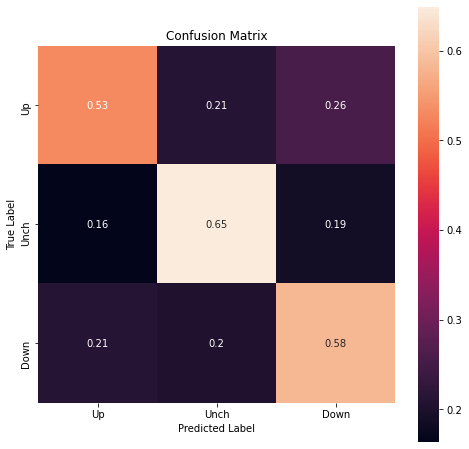

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(Y_test,1), np.argmax(trained_cnn_model.predict(X_test),1))
cm = cm.astype(float)

print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['Up','Unch', 'Down'], 
                  yticklabels=['Up','Unch', 'Down'], annot = True,square=True)
axs.set_title("Confusion Matrix")
axs.set_xlabel('Predicted Label')
axs.set_ylabel('True Label')

In [10]:
# serialize model to JSON
model_json = trained_cnn_model.to_json()
with open("/drive/My Drive/Colab Notebooks/cnn_model_arch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
trained_cnn_model.save_weights("/drive/My Drive/Colab Notebooks/cnn_model_w_1.h5")
print("Saved model to disk")

Saved model to disk
